# CNN Cancer Detection 

### Introduction:
This notebook is a binary image classification problem where I identify metastatic cancer in small image patches taken from larger digital pathology scans using CNN. There are 220k entries with an id and a label feature.

In [27]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import shutil
import tensorflow as tf
import keras.backend as K

from glob import glob
from skimage.io import imread
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

In [7]:
# Using GPU to do training.
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# EDA

In [16]:
train_labels_df = pd.read_csv("train_labels.csv")
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
# Check for missing data
train_labels_df.isna().sum()

id       0
label    0
dtype: int64

In [12]:
print(f"Train pictures: {len(os.listdir('train/'))}")
print(f"Test pictures: {len(os.listdir('test/'))}")

Train pictures: 220027
Test pictures: 57460


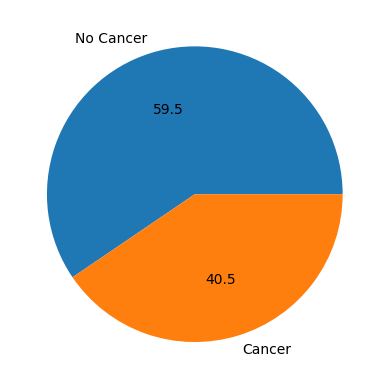

<Figure size 2000x2000 with 0 Axes>

In [13]:
labels_count = train_labels_df.label.value_counts()
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], autopct='%1.1f')
plt.figure(figsize=(20,20))
plt.show()

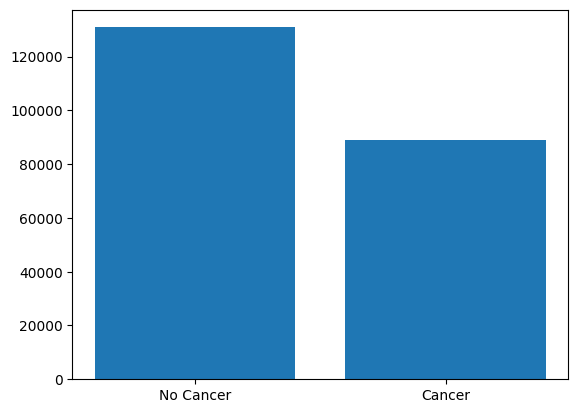

<Figure size 2000x2000 with 0 Axes>

In [14]:
labels_count = train_labels_df.label.value_counts()
plt.bar(x=["No Cancer", "Cancer"], height=labels_count)
plt.figure(figsize=(20,20))
plt.show()

I will be relying on the label stating the image has metastases cancer instead of looking at the images myself. Let's add the filepath of each image to the corresponding id for ease.

In [18]:
train_path = 'train/'
# Add image paths to the data frame for ease.
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[1].split(".")[0])
df_data = df.merge(train_labels_df, on = "id")

There's simply too many images for the kernel's memory so I purposely used a smaller size instead of the full training data.

In [19]:
# There's way too many images and kernel kept running out of memory so I took a
# smaller sample size of 5k per label type, so 10k in total.
SAMPLE_SIZE = 5000

df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 123)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 123)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))
print(df_data.head())
print(df_data.info())


                                                   path  \
5381  train/d2cd8b35850b65d1b249aa27cb45000a8e0ad6a4...   
3781  train/a5b7d32fd0fbc256c3604e1f967cf93197929cf7...   
3223  train/8198798e5d13a8fc750326ad74d168e713aad768...   
3320  train/00c37bfd185781b2495d84f4fd0c716fe7dcaabf...   
7261  train/118a34dfbc826fe64635114989fe75723d697f04...   

                                            id  label  
5381  d2cd8b35850b65d1b249aa27cb45000a8e0ad6a4      1  
3781  a5b7d32fd0fbc256c3604e1f967cf93197929cf7      0  
3223  8198798e5d13a8fc750326ad74d168e713aad768      0  
3320  00c37bfd185781b2495d84f4fd0c716fe7dcaabf      0  
7261  118a34dfbc826fe64635114989fe75723d697f04      1  
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 5381 to 2787
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10000 non-null  object
 1   id      10000 non-null  object
 2   label   10000 non-null  int64 
dtypes: int64(1), object

Using imread to change the image to a numeric array.

In [20]:
df_data['image'] = df_data['path'].map(imread)
df_data.sample(3)

,path,id,label,image
2233,train/a63ed806ad35a8af327618e8d9d7b5b6fb77ae3b...,a63ed806ad35a8af327618e8d9d7b5b6fb77ae3b,0,"[[[232, 159, 176], [218, 149, 167], [252, 188,..."
2176,train/d9333418d15268ed03e333e92a1c69beb3526503...,d9333418d15268ed03e333e92a1c69beb3526503,0,"[[[101, 37, 134], [245, 179, 255], [200, 134, ..."
8343,train/3d1e7ea2953611ef02509b566e2a585d545d4047...,3d1e7ea2953611ef02509b566e2a585d545d4047,1,"[[[185, 98, 195], [133, 51, 151], [163, 91, 19..."


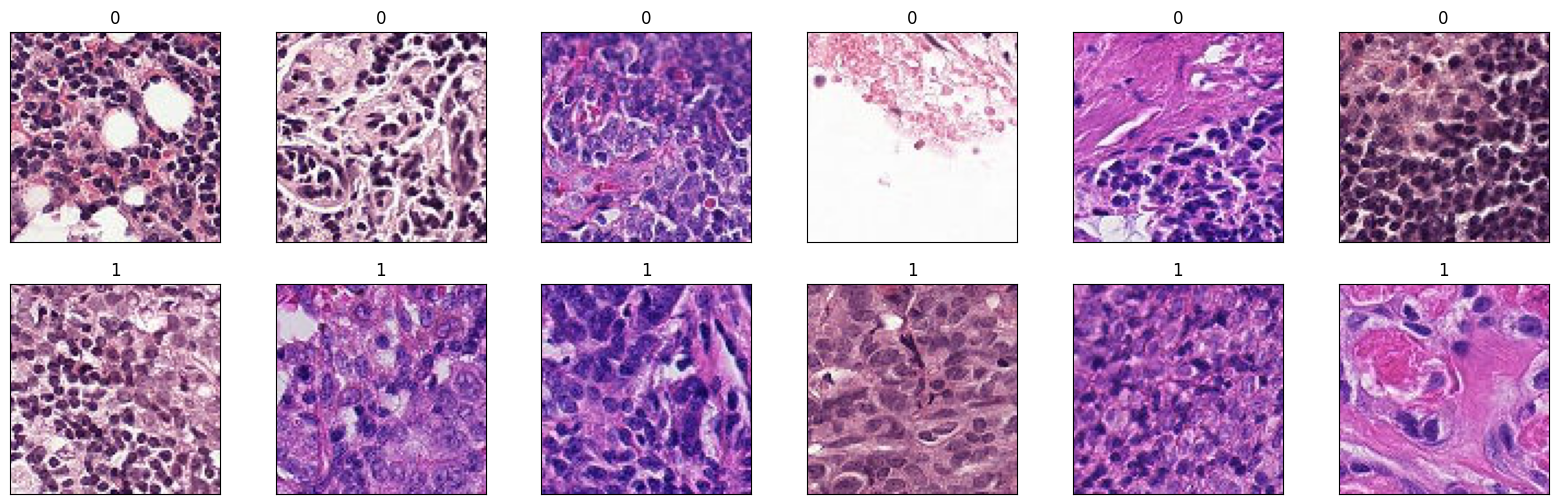

In [21]:
images = [(df_data['image'][0], df_data['label'][0]),
          (df_data['image'][1], df_data['label'][1]),
          (df_data['image'][2], df_data['label'][2]),
          (df_data['image'][3], df_data['label'][3]),
          (df_data['image'][4], df_data['label'][4]),
          (df_data['image'][5], df_data['label'][5]),
          (df_data['image'][7500], df_data['label'][7500]),
          (df_data['image'][7501], df_data['label'][7501]),
          (df_data['image'][7502], df_data['label'][7502]),
          (df_data['image'][7503], df_data['label'][7503]),
          (df_data['image'][7504], df_data['label'][7504]),
          (df_data['image'][7505], df_data['label'][7505])]

# show 12 images
fig = plt.figure(figsize=(20, 6))
for i in range(len(images)):
    ax = fig.add_subplot(2, 12 // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i][0])
    ax.set_title(images[i][1])

I can't really tell what the differences between cancer and not cancer so starting our model we'll create our set of inputs. We can do this by using np.stack to create a 4-rank tensor: 10,000 observations where each one is a 96x96x3 image.

In [22]:
images = np.stack(list(df_data.image), axis = 0)
images.shape

(10000, 96, 96, 3)

# Modeling


In [23]:
# Train on 80% of our sample size
train_size = 0.8

# encode them
encoder = LabelBinarizer()
y = encoder.fit_transform(df_data.label)
x = images

train_tensors, test_tensors, train_targets, test_targets = train_test_split(x, y, train_size=train_size, random_state=123)

valid_size = int(0.5 * len(test_tensors))
# Use half for the validation_data parameter
valid_tensors = test_tensors[:valid_size]
valid_targets = test_targets[:valid_size]
test_tensors = test_tensors[valid_size:]
test_targets = test_targets[valid_size:]

### Hyperparameter Tuning

Some minor hyperparameter tuning I did was the early stopping of the model per epoch. Waiting a bit longer sometimes gets us a better result so I ended up with 5 seconds for patience.

In [24]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(filepath='weights.hdf5.keras',
                               verbose=1, save_best_only=True)
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation = 'elu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation = 'elu'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation = 'elu'))

model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

/home/basilp/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744587086.828138  209363 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 25
model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=80, verbose=1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/25


I0000 00:00:1744587091.880747  210542 service.cc:152] XLA service 0x7f0870003f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744587091.880801  210542 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-13 19:31:31.938461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744587092.283926  210542 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-13 19:31:33.730379: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng11{k2=2,k3=0} for conv %cudnn-conv-bias-activation.36 = (f32[80,16,96,96]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,3,96,96]{3,2,1,0} %bitcast.12707, f32[16,3,3,3]{3,2,1,0} %bitcast.12698, f32[16]{0} %bitcast.13230), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

  1/100 ━━━━━━━━━━━━━━━━━━━━ 26:20 16s/step - accuracy: 0.6375 - loss: 0.7950

I0000 00:00:1744587106.444017  210542 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6233 - loss: 1.1421
Epoch 1: val_loss improved from inf to 0.54405, saving model to weights.hdf5.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 243ms/step - accuracy: 0.6259 - loss: 1.1251 - val_accuracy: 0.7630 - val_loss: 0.5441
Epoch 2/25
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7538 - loss: 0.5324
Epoch 2: val_loss did not improve from 0.54405
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7539 - loss: 0.5323 - val_accuracy: 0.7310 - val_loss: 0.5734
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7668 - loss: 0.5016
Epoch 3: val_loss did not improve from 0.54405
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7667 - loss: 0.5017 - val_accuracy: 0.6740 - val_loss: 0.6243
Epoch 4/25
 96/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7542 - loss: 0.5236
Epoch 4: val_loss did not improve from 0.54405
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7548 - loss: 0.5227 - val_

In [26]:
model.load_weights('weights.hdf5.keras')

cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

test_accuracy = 100 * np.sum(np.round(cancer_predictions).astype('int32')==test_targets.flatten())/len(cancer_predictions)
print(f'Test accuracy: {test_accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [28]:
score = roc_auc_score(np.round(cancer_predictions).astype('int32'), test_targets)
print(f"roc score: {score}")


roc score: 0.8187080753353972


In [29]:
base_tile_dir = 'test/'
test_df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
test_df['id'] = test_df.path.map(lambda x: x.split('/')[1].split(".")[0])

In [ ]:
test_df['image'] = test_df['path'].map(imread)

In [ ]:
test_images = np.stack(test_df.image, axis = 0)
test_images.shape

In [ ]:
predicted_labels =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_images]

In [ ]:
predictions = np.array(predicted_labels)
test_df['label'] = predictions
submission = test_df[["id", "label"]]
submission.head()

In [ ]:
submission.to_csv("submission.csv", index = False, header = True)